In [ ]:
# default_exp subcoco_effdet_lightning

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Object Detection using EffDet and Pytorch Lightning

Instead of using higher level library such as IceVision, I am going to use [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) and [EffDet directly](https://github.com/rwightman/efficientdet-pytorch) without IceVision and FastAI.

In [ ]:
#export
import json, os, requests, sys, tarfile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import random

from collections import defaultdict
from functools import reduce
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

In [ ]:
#hide

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    os.chdir('/content/drive/My Drive/ColabData')
    !wget -O 'mcbbox/subcoco_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_utils.py
    !wget -O 'mcbbox/subcoco_lightning_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_lightning_utils.py
    !pip install torch torchvision pytorch_lightning effdet gpumonitor albumentations==0.4.6

print(f'Current Directory is now {os.getcwd()}')

Current Directory is now /home/brian/Projects/mcbbox


In [ ]:
#export
import albumentations as A
import cv2, torch, torchvision
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.multiprocessing
from albumentations.pytorch import ToTensorV2
from effdet.config.model_config import get_efficientdet_config
from effdet.factory import create_model
from effdet.bench import DetBenchPredict, DetBenchTrain, unwrap_bench
from effdet.loss import DetectionLoss, loss_fn
from torch import nn
from torch.nn.modules import module
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from mcbbox.subcoco_utils import *
from mcbbox.subcoco_lightning_utils import *

torch.multiprocessing.set_sharing_strategy('file_system')
print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}, Albumentation {A.__version__}")

if is_notebook():
    from nbdev.showdoc import *

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.1, pytorch_lightning 1.0.4, Albumentation 0.5.0
Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.1, pytorch_lightning 1.0.4, Albumentation 0.5.0


# Setup the Run

Centralize test run vs prod time parameters

In [ ]:
#hide
test = True
backbone_name = "tf_efficientdet_lite0"
if test:
    img_sz, head_runs, full_runs, save_top, lr, calc_metrics = 512, 1, 1, 1, 0.01, True  # must be 512 as effdet backbone is img_sz specific
    bs, acc, workers = 3, 12, 4
    datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
else:
    img_sz, head_runs, full_runs, save_top, lr, calc_metrics = 512, 10, 100, 1, 0.01, False
    bs, acc, workers = (16,2,8) if IN_COLAB else (4,8,5)
    datadir, url, img_subdir = 'workspace', 'https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', 'train_sample'
    
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

## Download Data and Check Annotations

Let's download and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
#hide
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 542959, 'file_name': '000000542959.jpg'},
 [{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
  {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
  {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86},
  {'image_id': 542959,
   'bbox': [110.48, 110.82, 14.55, 15.22],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [96.63, 50.18, 18.67, 13.46],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [0.69, 111.73, 11.8, 13.06],
   'category_id': 62}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image... Print out number of boxes per category to see if the distribution is not too unbalanced...

In [ ]:
#hide
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 200, Boxes 688, avg (w,h) (128.0, 128.0)avg cats/img 7.0, avg boxs/img 3.4, avg boxs/cat 114.7.
Image means by channel [126.2909314  109.02263367 100.61073242], std.dev by channel [65.60744282 65.09696176 60.4631069 ]


{'chair': 284, 'vase': 64, 'tv': 26, 'couch': 40, 'book': 254, 'remote': 20}

## Look at Images

Let's look at an image annotation.

In [ ]:
best_img_pos = None
max_boxs = 0
for img_pos in range(len(train_json['images'])):  
    img_id = train_json['images'][img_pos]['id']
    l2bs = stats.img2l2bs.get(img_id, {})
    n_boxs =  reduce((lambda x, y: x + y), [1 if len(bs) > 0 else 0 for bs in l2bs.values()], 0)
    if n_boxs >= max_boxs:
        best_img_pos = img_pos
        max_boxs = n_boxs

print(f'best_img_pos {best_img_pos}')
best_img_id = train_json['images'][best_img_pos]['id']
l2bs = stats.img2l2bs[best_img_id]
best_img_fname = stats.img2fname[best_img_id]
best_img_id, best_img_fname, l2bs

best_img_pos 89


(107903,
 '000000107903.jpg',
 {0: [],
  1: [(90.86, 85.09, 33.16, 38.46)],
  2: [(81.75, 56.7, 42.12, 31.66), (91.19, 85.84, 33.11, 37.77)],
  3: [(31.67, 36.95, 29.82, 24.54)],
  4: [],
  5: [(70.08, 91.25, 9.82, 5.1),
   (67.28, 77.63, 16.32, 5.83),
   (37.7, 76.38, 1.16, 4.6),
   (5.12, 73.58, 3.41, 8.88),
   (115.35, 75.7, 8.47, 2.68),
   (69.76, 93.02, 9.79, 6.08),
   (64.86, 87.24, 9.3, 4.97),
   (8.36, 63.94, 1.09, 6.74),
   (115.74, 74.44, 8.03, 3.33),
   (77.48, 91.77, 6.14, 2.82),
   (8.33, 73.88, 1.55, 8.13)],
  6: [(6.2, 42.53, 3.48, 3.95)]})

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.
Pick some random image to test drive the box overlay code...

img = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7F912A605790>


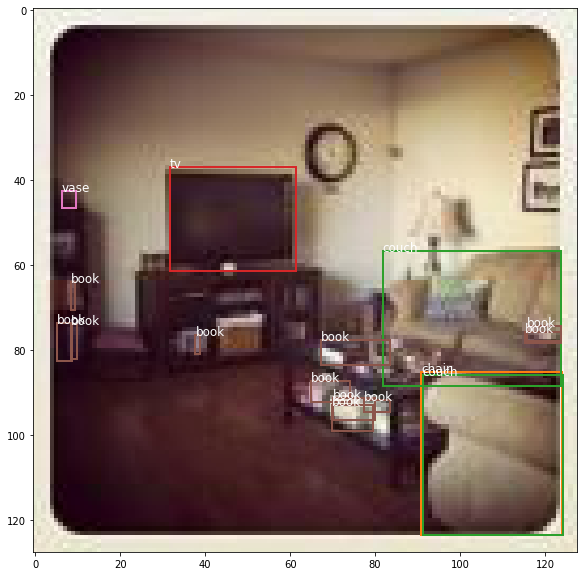

In [ ]:
img = Image.open(Path(img_dir)/stats.img2fname[best_img_id])
print(f"img = {img}")
overlay_img_bbox(img, stats.img2l2bs[best_img_id], stats.lbl2name)

## Packaging Model and Metric Into A Lightning Module

We can get sub modules in effdet like so
```
model =  create_model(
    backbone_name,
    bench_task='train',
    num_classes=7,
    pretrained=False,
    pretrained_backbone=True,
)

for m in model.modules():
    if type(m) is torch.nn.BatchNorm2d: print(m)
```

In [ ]:
# export
class EffDetModule(AbstractDetectorLightningModule):
    def __init__(self, backbone_name:str="tf_efficientdet_lite0", **kwargs):
        AbstractDetectorLightningModule.__init__(self, backbone_name=backbone_name, **kwargs)
        self.config = get_efficientdet_config(model_name=backbone_name)
        self.loss_fn = DetectionLoss(self.config)
    
    def create_model(self, backbone_name, num_classes=1, **kwargs): 
        return create_model(
            backbone_name,
            bench_task='',
            num_classes=num_classes + 1,
            pretrained=False,
            pretrained_backbone=True,
            bench_labeler=True,
        )
        
    def get_main_model(self):
        main_mod = self.model
        if type(main_mod) is DetBenchPredict or type(main_mod) is DetBenchTrain:
            main_mod = main_mod.model
        return main_mod
        
    def get_head(self): 
        main_mod = self.get_main_model()
        return [main_mod.class_net, main_mod.box_net]
        
    def get_backbone(self):
        main_mod = self.get_main_model()
        return main_mod.backbone

    def convert_raw_predictions(self, raw_preds: torch.Tensor, detection_threshold: float=0) -> List[dict]:
        #print(f"raw_preds ={raw_preds}")
        dets = raw_preds.detach().cpu().numpy()
        preds = []
        for det in dets:
            if detection_threshold > 0:
                scores = det[:, 4]
                keep = scores > detection_threshold
                det = det[keep]
            pred = {
                "boxes": det[:, :4].clip(0, self.img_sz),
                "scores": det[:, 4],
                "labels": det[:, 5].astype(int),
            }
            preds.append(pred)

        return preds
    
    def stack_images(self, xs):
        xs_stack = torch.stack([xs[i] if i < len(xs) else torch.zeros((3, self.img_sz, self.img_sz)).cuda() for i in range(self.bs)])
        return xs_stack
        
    def pack_target(self, ys):
        target = dict(
            bbox=[ys[yi]['boxes'] if yi < len(ys) else torch.zeros((1,4)).cuda() for yi in range(self.bs)], 
            cls=[ys[yi]['labels'] if yi < len(ys) else torch.Tensor([-1]).cuda() for yi in range(self.bs)]
        )
        return target
        
    def training_step(self, train_batch, batch_idx):
        if self.noisy: print('Entering training_step')
        self.model.train()
        bench = DetBenchTrain(unwrap_bench(self.model))
        bench.cuda()
        xs, ys = self.fix_boxes_batch(*train_batch)
        if len(xs) <= 0: return 0

        target = self.pack_target(ys)
        xs_stack = self.stack_images(xs)
        losses = bench(xs_stack, target)['loss']
        if self.noisy: print(f'Exiting training_step, returning {losses}')
        return losses
    
    def validation_step(self, val_batch, batch_idx):
        if self.noisy: print('Entering validation_step')
        # turn off auto gradient for validation step
        with torch.no_grad():
            xs, ys = val_batch
#             predictor = DetBenchPredict(unwrap_bench(self.model))
#             predictor.cuda()
#             raw_preds = predictor(torch.stack(xs).cuda())
#             preds = self.convert_raw_predictions(raw_preds)
#             metrics = self.metrics(preds, ys)
            bench = DetBenchTrain(unwrap_bench(self.model))
            bench.cuda()
            target = self.pack_target(ys)
            xs_stack = self.stack_images(xs)
            losses = bench(xs_stack, target)['loss']
        
        result = { 'val_loss': losses,
#             'val_acc': metrics[:]['val_acc'].mean(),  'val_coco': metrics[:]['val_coco'.mean(), 
        } 
        if self.noisy: print(f'Exiting validation_step, returning {result}')
        return result

    def forward(self, imgs):
        if self.noisy: print(f'Entering forward, training = {self.training}')
        with torch.no_grad():
            self.model.eval()
            bench = DetBenchPredict(unwrap_bench(self.model))
            raw_preds = bench(torch.stack(imgs))
            preds = self.convert_raw_predictions(raw_preds)
        if self.noisy: print(f'Exiting forward, returning {preds}')
        return preds

## Neural Network Architecture Model

On my Dell XPS15 GTX-1050 GPU w/ 4GB VRAM,  I can average 1 epoc every 120 min or so, at bs=2 acc=16, img 384x384, with unfrozen backbone.

Using my GCP w/ V100 of 16GB VRAM, I can fit bs=12 for sample_coco, acc=16, img 384x384, with unfrozen backbone, 1 epoc every ~25 minutes.

In [ ]:
#hide
if torch.cuda.is_available():
    effdet_model, last_model_path = run_training(EffDetModule, backbone_name, stats, img_dir, 
        resume_ckpt_fname=f'{backbone_name}-{img_sz}-last.ckpt', 
        img_sz=img_sz, lr=lr, bs=bs, acc=acc, workers=workers, head_runs=head_runs, full_runs=full_runs,
        save_top=save_top, test=test, calc_metrics=calc_metrics
    )

    print(f"last_model_path saved = {last_model_path}")

Training with image size 512, learning rate 0.01, for 1+1 epochs.
Loading previously saved model: models/tf_efficientdet_lite0-512-last.ckpt...


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory models exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training with image size 512, learning rate 0.01, for 1+1 epochs.



  | Name    | Type          | Params
------------------------------------------
0 | model   | EfficientDet  | 3 M   
1 | loss_fn | DetectionLoss | 0     
INFO:lightning:
  | Name    | Type          | Params
------------------------------------------
0 | model   | EfficientDet  | 3 M   
1 | loss_fn | DetectionLoss | 0     


Entering validation_step


/usr/local/lib/python3.8/dist-packages/effdet/object_detection/matcher.py:175: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor([ignored_value, unmatched_value], dtype=input_tensor.dtype, device=input_tensor.device),


Exiting validation_step, returning {'val_loss': tensor(2.2458, device='cuda:0')}
Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(2.0030, device='cuda:0')}
Entering validation_epoch_end
Exiting validation_epoch_end, returning {'val_loss': tensor(2.1244, device='cuda:0')}


Entering training_step
Exiting training_step, returning 1.0768749713897705
Entering training_step
Exiting training_step, returning 1.6633472442626953
Entering training_step
Exiting training_step, returning 1.166011095046997
Entering training_step
Exiting training_step, returning 1.2340211868286133
Entering training_step
Exiting training_step, returning 1.3322410583496094
Entering training_step
Exiting training_step, returning 1.4074459075927734
Entering training_step
Exiting training_step, returning 1.3271722793579102
Entering training_step
Exiting training_step, returning 1.1742665767669678
Entering training_step
Exiting training_step, returning 1.0036029815673828
Entering training_step
Exiting training_step, returning 1.1611042022705078
Entering training_step
Exiting training_step, returning 0.956494927406311
Entering training_step
Exiting training_step, returning 0.9522383213043213
Entering training_step
Exiting training_step, returning 1.0649607181549072
Entering training_step
Exit

Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(2.3221, device='cuda:0')}
Entering validation_step


Epoch 0: val_loss reached 2.17380 (best 2.17380), saving model to /home/brian/Projects/mcbbox/models/tf_efficientdet_lite0-head-512-epoch=000-val_loss=2.174.ckpt as top 1
INFO:lightning:Epoch 0: val_loss reached 2.17380 (best 2.17380), saving model to /home/brian/Projects/mcbbox/models/tf_efficientdet_lite0-head-512-epoch=000-val_loss=2.174.ckpt as top 1


Exiting validation_step, returning {'val_loss': tensor(2.0255, device='cuda:0')}
Entering validation_epoch_end
Exiting validation_epoch_end, returning {'val_loss': tensor(2.1738, device='cuda:0')}


Saving latest checkpoint...
INFO:lightning:Saving latest checkpoint...



[0] GeForce GTX 1050 | 45'C,  28 % |  2938 /  4042 MB | brian(605M) root(790M) brian(72M) brian(194M)



GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | model   | EfficientDet  | 3 M   
1 | loss_fn | DetectionLoss | 0     
INFO:lightning:
  | Name    | Type          | Params
------------------------------------------
0 | model   | EfficientDet  | 3 M   
1 | loss_fn | DetectionLoss | 0     


Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(2.0463, device='cuda:0')}
Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(1.8181, device='cuda:0')}
Entering validation_epoch_end
Exiting validation_epoch_end, returning {'val_loss': tensor(1.9322, device='cuda:0')}


Entering training_step
Exiting training_step, returning 1.0871220827102661
Entering training_step
Exiting training_step, returning 1.4213440418243408
Entering training_step
Exiting training_step, returning 0.9475403428077698
Entering training_step
Exiting training_step, returning 1.5223138332366943
Entering training_step
Exiting training_step, returning 1.031830906867981
Entering training_step
Exiting training_step, returning 1.3062889575958252
Entering training_step
Exiting training_step, returning 1.1280041933059692
Entering training_step
Exiting training_step, returning 1.418394923210144
Entering training_step
Exiting training_step, returning 1.3868566751480103
Entering training_step
Exiting training_step, returning 1.2857602834701538
Entering training_step
Exiting training_step, returning 1.2029404640197754
Entering training_step
Exiting training_step, returning 1.1719956398010254
Entering training_step
Exiting training_step, returning 1.218592882156372
Entering training_step
Exiti

Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(2.1769, device='cuda:0')}
Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(1.7312, device='cuda:0')}
Entering validation_step
Exiting validation_step, returning {'val_loss': tensor(2.0553, device='cuda:0')}
Entering validation_step


Epoch 0: val_loss reached 1.98691 (best 1.98691), saving model to /home/brian/Projects/mcbbox/models/tf_efficientdet_lite0-full-512-epoch=000-val_loss=1.987.ckpt as top 1
INFO:lightning:Epoch 0: val_loss reached 1.98691 (best 1.98691), saving model to /home/brian/Projects/mcbbox/models/tf_efficientdet_lite0-full-512-epoch=000-val_loss=1.987.ckpt as top 1


Exiting validation_step, returning {'val_loss': tensor(1.9843, device='cuda:0')}
Entering validation_epoch_end
Exiting validation_epoch_end, returning {'val_loss': tensor(1.9869, device='cuda:0')}


Saving latest checkpoint...
INFO:lightning:Saving latest checkpoint...



[0] GeForce GTX 1050 | 51'C,  41 % |  3021 /  4042 MB | brian(661M) root(798M) brian(72M) brian(193M)

last_model_path saved = /home/brian/Projects/mcbbox/models/tf_efficientdet_lite0-512-last.ckpt


Entering forward, training = False
Exiting forward, returning [{'boxes': array([[148.36853  , 125.35979  , 256.17108  , 244.18004  ],
       [239.86194  , 310.87833  , 431.9182   , 478.0629   ],
       [244.58867  , 307.36472  , 378.2616   , 423.06326  ],
       [244.58867  , 307.36472  , 378.2616   , 423.06326  ],
       [241.36894  , 322.10107  , 418.83545  , 473.3081   ],
       [256.03912  , 367.64777  , 456.0865   , 500.19672  ],
       [263.05777  , 278.9115   , 388.48422  , 379.97675  ],
       [227.97893  , 239.76047  , 386.26624  , 451.94534  ],
       [305.20038  ,   0.9422302, 482.9079   , 286.52704  ],
       [256.03912  , 367.64777  , 456.0865   , 500.19672  ],
       [174.90643  , 110.935486 , 265.50854  , 217.19653  ],
       [259.37592  ,  82.06006  , 455.33167  , 320.90814  ],
       [274.14383  , 250.6192   , 392.66812  , 346.85248  ],
       [248.24442  , 256.08878  , 377.80734  , 377.96658  ],
       [242.2964   , 151.54456  , 414.19043  , 393.84332  ],
       [244.

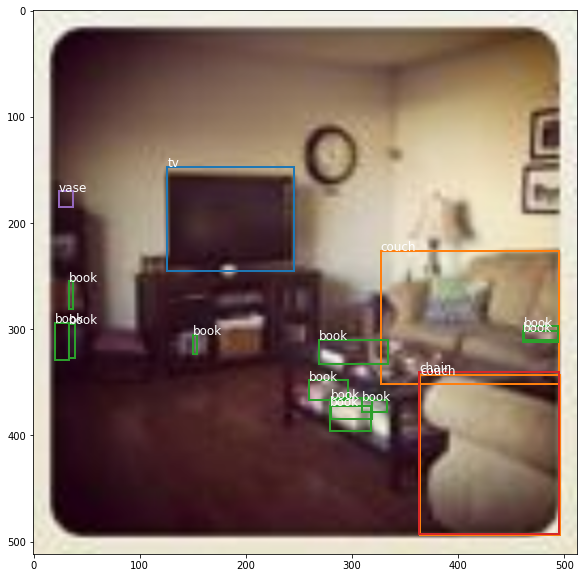

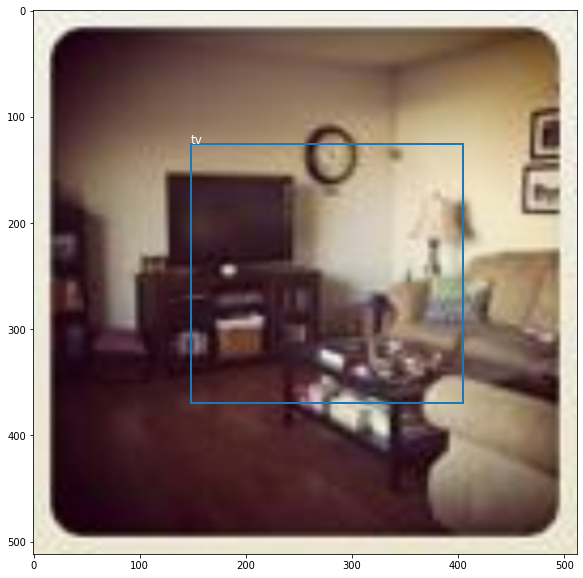

In [ ]:
bbox_aware_test_tfms=A.Compose([
    A.Resize(width=img_sz, height=img_sz),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_set = SubCocoDataset(img_dir, stats, img_ids=[best_img_id], bbox_aware_tfms=bbox_aware_test_tfms)

if torch.cuda.is_available():
    x, y = test_set[0] 
    pimg = torchvision.transforms.ToPILImage()(x)
    tgt_l2bs = defaultdict(empty_list)
    for l, b in zip(list(y['labels']), y['boxes']):
        tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

    overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

    effdet_model.freeze()
    effdet_model.eval()
    pred = effdet_model.forward([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=.35, img_sz=x.shape[1])
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)
    print(f"pred labels to boxes: { {k:len(v) for k, v in pred_l2bs.items()} }")

Compare with Original Image before transformations incl. Normalization and Resize.

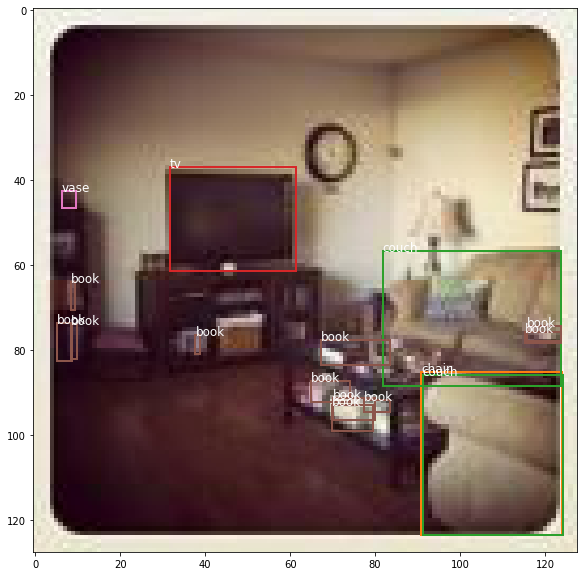

In [ ]:
#hide
if torch.cuda.is_available():
    img_id = int(y['image_id'])
    img = Image.open(Path(img_dir)/stats.img2fname[img_id])
    overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

## Reloading Saved Checkpoint using Pytorch Lightning

pred labels to boxes: {3: 1}


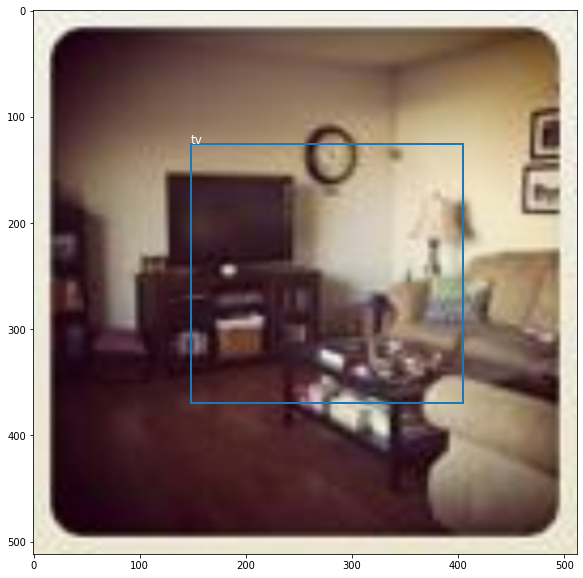

In [ ]:
#hide
if torch.cuda.is_available():
    last_model_path = f'models/{backbone_name}-{img_sz}-last.ckpt'
    pretrained_model = EffDetModule.load_from_checkpoint(last_model_path, backbone_name=backbone_name, bs=bs, steps_per_epoch=0, num_classes=len(stats.lbl2name), img_sz=img_sz)
    pretrained_model.freeze()
    x, y = test_set[0] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.35, img_sz=x.shape[1])
    pimg = torchvision.transforms.ToPILImage()(x)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)
    print(f"pred labels to boxes: { {k:len(v) for k, v in pred_l2bs.items()} }")

## Saving and Reloading using Underlying Pytorch

In [ ]:
# export
def save_final(effdet_model, model_save_path):
    torch.save(effdet_model.model.state_dict(), model_save_path)

In [ ]:
#hide
if torch.cuda.is_available():
    model_save_path = f'models/{backbone_name}-{img_sz}-final.pth'
    save_final(effdet_model, model_save_path)
    pretrained_model = EffDetModule(bs=bs, num_classes=len(stats.lbl2name), img_sz=img_sz, steps_per_epoch=0)
    pretrained_model.model.load_state_dict(torch.load(model_save_path))
    pretrained_model.freeze()

pred labels to boxes: {3: 1}


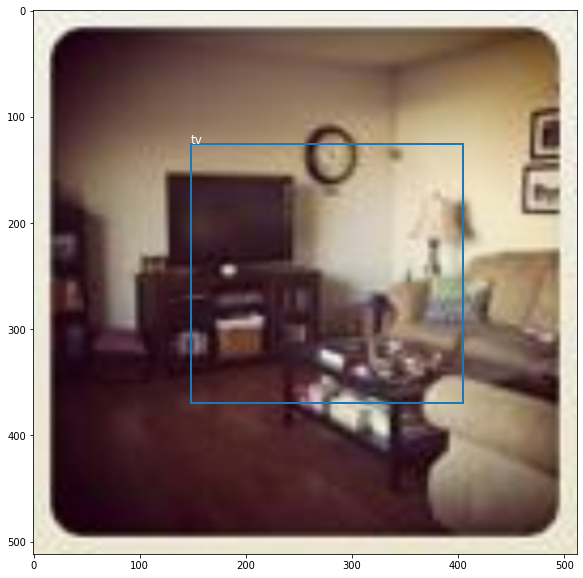

In [ ]:
#hide
if torch.cuda.is_available():
    x, y = test_set[0] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], img_sz=x.shape[1], cutoff=0.35)
    pimg = torchvision.transforms.ToPILImage()(x)

    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)
    print(f"pred labels to boxes: { {k:len(v) for k, v in pred_l2bs.items()} }")